# Galaxies within 0.2 dex of Main Sequence Relation

#### Cosmology: Planck2015
#### Simulation Name: TNG-50
#### Redshift Bin:2.45-3.05  
25   0.25   3

In [1]:
import illustris_python as il
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.cosmology import Planck15 as cosmo
from scipy.optimize import curve_fit

# PREPARING THE DATA
The following data is available:<br>
1. Subhalo Mass
2. $R_{eff}$
3. Stellar Mass
4. Dark Matter Mass
5. Gaseous Mass
6. SFR
7. $V_{max}$
8. Velocity Dispersion

In [2]:
basePath = 'sims.TNG/TNG50-1/output'
full_data=il.groupcat.loadSubhalos(basePath,25,fields=['SubhaloMassType','SubhaloHalfmassRad','SubhaloHalfmassRadType','SubhaloFlag','SubhaloMass','SubhaloSFR','SubhaloVmax','SubhaloVelDisp'])
full_data

{'count': 7935350,
 'SubhaloMassType': array([[5.0365894e+01, 4.3582489e+02, 0.0000000e+00, 0.0000000e+00,
         1.6443165e+01, 3.8426492e-02],
        [3.5403016e+00, 4.1420689e+01, 0.0000000e+00, 0.0000000e+00,
         8.6580715e+00, 1.9120252e-02],
        [2.1250439e+00, 1.2200900e+01, 0.0000000e+00, 0.0000000e+00,
         1.1295301e+00, 1.0395086e-03],
        ...,
        [0.0000000e+00, 8.9136633e-04, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 9.5283991e-04, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 8.6062960e-04, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00]], dtype=float32),
 'SubhaloHalfmassRad': array([228.65698  ,  30.374176 ,  35.53252  , ...,   2.714767 ,
          4.0363526,   3.3730671], dtype=float32),
 'SubhaloHalfmassRadType': array([[251.84769  , 232.52185  ,   0.       ,   0.       ,   3.2104099,
           0.       ],
        [ 15.0779

In [3]:
a=0.25
h=0.6774

z1_Subhaloflag=full_data['SubhaloFlag']
z1_Subhalomass_gas=full_data['SubhaloMassType'][:,0]*1e10/h
z1_Subhalomass_star=full_data['SubhaloMassType'][:,4]*1e10/h
z1_Subhalomass_dm=full_data['SubhaloMassType'][:,1]*1e10/h
z1_Subhalo_sreff=full_data['SubhaloHalfmassRadType'][:,4]*a/h
z1_Subhalo_reff=full_data['SubhaloHalfmassRad']*a/h
z1_Subhalo_sfr=full_data['SubhaloSFR']
z1_Subhalo_Flag=full_data['SubhaloFlag']
z1_Subhalo_Vmax=full_data['SubhaloVmax']
z1_Subhalo_Sigma=full_data['SubhaloVelDisp']
z1_Subhalo_mass=full_data['SubhaloMass']*1e10/h
z1=np.full((len(z1_Subhalomass_gas),1),3)

Conversion of units from comoving to physical, $\frac{10^{10}}{h} M_{\odot}$ to $M_{\odot}$ etc

Pick galaxies of cosmological origin only, remove ones with SFR and Mass<0

In [4]:
def good_galaxies(z_fields):
    z_Subhaloflag,z_Subhalomass_gas,z_Subhalomass_star,z_Subhalomass_dm,z_Subhalo_reff,z_Subhalo_sreff,z_Subhalo_sfr,z_Subhalo_Vmax,z_Subhalo_Sigma,z_Subhalo_mass,z=z_fields
    good_ones=np.where((z_Subhaloflag==True) &(z_Subhalomass_star > 0) & (z_Subhalo_sfr > 0) &(z_Subhalomass_star != np.nan) &(z_Subhalo_sfr != np.nan))

    newfields=[field[good_ones] for field in z_fields]
    return newfields

In [5]:
z1_Subhaloflag,z1_Subhalomass_gas,z1_Subhalomass_star,z1_Subhalomass_dm,z1_Subhalo_reff,z1_Subhalo_sreff,z1_Subhalo_sfr,z1_Subhalo_Vmax,z1_Subhalo_Sigma,z1_Subhalo_mass,z1=good_galaxies([z1_Subhaloflag,z1_Subhalomass_gas,z1_Subhalomass_star,z1_Subhalomass_dm,z1_Subhalo_reff,z1_Subhalo_sreff,z1_Subhalo_sfr,z1_Subhalo_Vmax,z1_Subhalo_Sigma,z1_Subhalo_mass,z1])

# Speagle's Relation
log SFR(M∗, t) = (0.84 ± 0.02 − 0.026 ± 0.003 × t) log M∗−(6.51 ± 0.24 − 0.11 ± 0.03 × t)

In [6]:
def speagle_params(z):
    t=cosmo.age(z).value
    return 0.84-0.026*t, -(6.51-0.11*t)

def speagle(z,logmass):
    return speagle_params(z)[0]*logmass+speagle_params(z)[1]

In [7]:
def pearson(z,logmass):
    slope=1.1+0.5*np.log(0.03+z)
    intercept=0.38+0.12*z-10.5*slope
    return slope*logmass+intercept

In [8]:
def santini(z,logmass):
    if z<2 and z>1.3:
        return 1.04*logmass-9.7+1.01
    elif z<3 and z>=2:
        return 1.16*logmass-9.7+1.22
    elif z==3:
        return 1.02*logmass-9.7+1.37

In [9]:
def iyer(z,logmass):
    t=cosmo.age(z).value
    return (0.80-0.017*t)*logmass-(6.487-0.039*t)

In [10]:
def compare_mainseq(z,log_ms,log_sfr):
    fig=plt.figure(figsize=(8,6))
    ax=fig.add_subplot(111)
    ax.plot(log_ms,log_sfr,'.',markersize=2)
    x=np.linspace(8,11.5,len(log_ms))
    pearson_values=pearson(z,x)
    speagle_values=speagle(z,x)
    santini_values=santini(z,x)
    iyer_values=iyer(z,x)
    
    ax.plot(x,pearson_values,label='Pearson et al 2018',linewidth=4,color='brown')
    ax.plot(x,speagle_values,label='Speagle et al 2014',linewidth=4,color='red')
    ax.plot(x,santini_values,label='Santini et al 2017',linewidth=4,color='green')
    ax.plot(x,iyer_values,label='Iyer et al 2018',linewidth=4,color='yellow')

    ax.set_xlim(8,11.5)
    ax.set_xlabel('log Galaxy Stellar Mass [$M_\odot$, $r < 2*r_{1/2 M_\star}$]')
    ax.set_ylabel('log Star Formation Rate [yr$^{-1}$]')
    ax.legend()
    plt.show()    

In [11]:
log_ms=np.log10(z1_Subhalomass_star)
log_sfr=np.log10(z1_Subhalo_sfr)

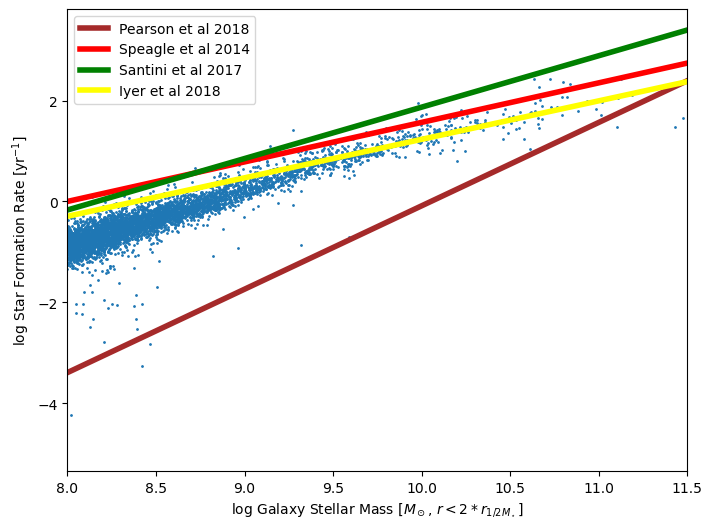

In [12]:
compare_mainseq(3,log_ms,log_sfr)

Iyer is a better fit

In [13]:
good_ones=np.where((abs(iyer(3,log_ms)-log_sfr)<0.6))
fields=z1_Subhalomass_gas,z1_Subhalomass_star,z1_Subhalomass_dm,z1_Subhalo_reff,z1_Subhalo_sreff,z1_Subhalo_sfr,z1_Subhalo_Vmax,z1_Subhalo_Sigma,z1_Subhalo_mass,z1
newfields=[field[good_ones] for field in fields]
z1_Subhalomass_gas,z1_Subhalomass_star,z1_Subhalomass_dm,z1_Subhalo_reff,z1_Subhalo_sreff,z1_Subhalo_sfr,z1_Subhalo_Vmax,z1_Subhalo_Sigma,z1_Subhalo_mass,z1=newfields

In [14]:
log_ms=np.log10(z1_Subhalomass_star)
log_sfr=np.log10(z1_Subhalo_sfr)

## Binning the Data

In [15]:
def bin_data(log_ms,log_sfr,nbins):
    mass_bins=np.linspace(log_ms.min(),log_ms.max(),nbins,endpoint=True)
    bin_indices=np.digitize(log_ms, mass_bins, right=False)
    binned_data={bin_start:[] for bin_start in mass_bins[0:-1]}

    for i, bin_start in enumerate(mass_bins[0:-1]):
        mask=bin_indices==i+1
        binned_data[bin_start]=list(zip(log_ms[mask],log_sfr[mask]))
        
    logms_binned=[(mass_bins[i]+mass_bins[i+1])/2 for i in range(len(mass_bins)-1)]
    logsfr_binned = [np.median([i[1] for i in binned_data[bin_start]]) for bin_start in mass_bins[0:-1]]
        
    return logms_binned,logsfr_binned

In [16]:
logms_binned,logsfr_binned=bin_data(log_ms,log_sfr,15)

## Attempting to Match Simulation Data with Observations

In [17]:
def line(x,m,c):
    return m*x+c

popt,pcov=curve_fit(line,logms_binned,logsfr_binned)

In [18]:
def plot_iyer(z,log_ms,log_sfr,logms_binned,logsfr_binned):
    fig=plt.figure(figsize=(10,8))
    ax=fig.add_subplot(111)
    ax.plot(log_ms,log_sfr,'.',markersize=2)
    x=np.linspace(8,11.5,len(log_ms))
    iyer_values=iyer(z,x)

    ax.plot(x,iyer_values,label='Iyer et al 2018',linewidth=4,color='brown')
    ax.plot(x,line(x,popt[0],popt[1]),label='Best Fit',linewidth=4,color='green')
    ax.plot(x,iyer_values+0.3,'--',color='black',linewidth=2)
    ax.plot(x,iyer_values-0.3,'--',color='black',linewidth=2)
    ax.scatter(logms_binned,logsfr_binned,color='orange',s=40,zorder=5)

    ax.set_xlim(8,11.5)
    ax.set_xlabel('log Galaxy Stellar Mass [$M_\odot$, $r < 2*r_{1/2 M_\star}$]')
    ax.set_ylabel('log Star Formation Rate [yr$^{-1}$]')
    ax.legend()
    plt.show()

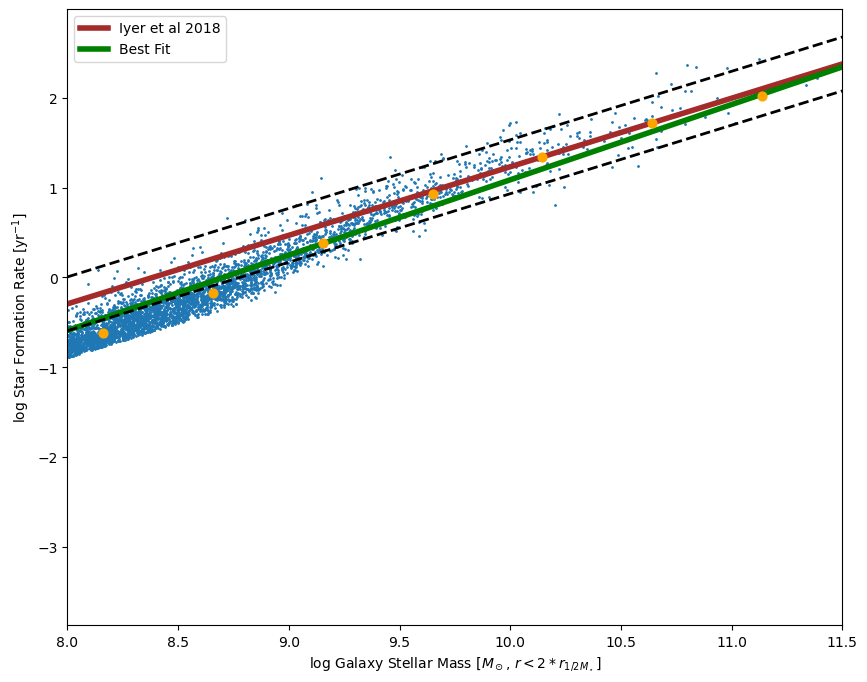

In [19]:
plot_iyer(3,log_ms,log_sfr,logms_binned,logsfr_binned)

# MASSSIZE

In [20]:
good_ones=np.where(z1_Subhalo_sreff > 0)
fields=[z1_Subhalomass_gas,z1_Subhalomass_star,z1_Subhalomass_dm,z1_Subhalo_reff,z1_Subhalo_sreff,z1_Subhalo_sfr,z1_Subhalo_Vmax,z1_Subhalo_Sigma,z1_Subhalo_mass,z1]

newfields=[field[good_ones] for field in fields]
z1_Subhalomass_gas,z1_Subhalomass_star,z1_Subhalomass_dm,z1_Subhalo_reff,z1_Subhalo_sreff,z1_Subhalo_sfr,z1_Subhalo_Vmax,z1_Subhalo_Sigma,z1_Subhalo_mass,z1=newfields

In [21]:
log_ms=np.log10(z1_Subhalomass_star)
log_sreff=np.log10(z1_Subhalo_sreff)

In [22]:
good_ones=np.where((log_ms > 8) & (log_ms <11.5))
fields=[z1_Subhalomass_gas,z1_Subhalomass_star,z1_Subhalomass_dm,z1_Subhalo_reff,z1_Subhalo_sreff,z1_Subhalo_sfr,z1_Subhalo_Vmax,z1_Subhalo_Sigma,z1_Subhalo_mass,z1]
newfields=[field[good_ones] for field in fields]
z1_Subhalomass_gas,z1_Subhalomass_star,z1_Subhalomass_dm,z1_Subhalo_reff,z1_Subhalo_sreff,z1_Subhalo_sfr,z1_Subhalo_Vmax,z1_Subhalo_Sigma,z1_Subhalo_mass,z1=newfields

In [23]:
log_ms=np.log10(z1_Subhalomass_star)
log_reff=np.log10(z1_Subhalo_sreff)

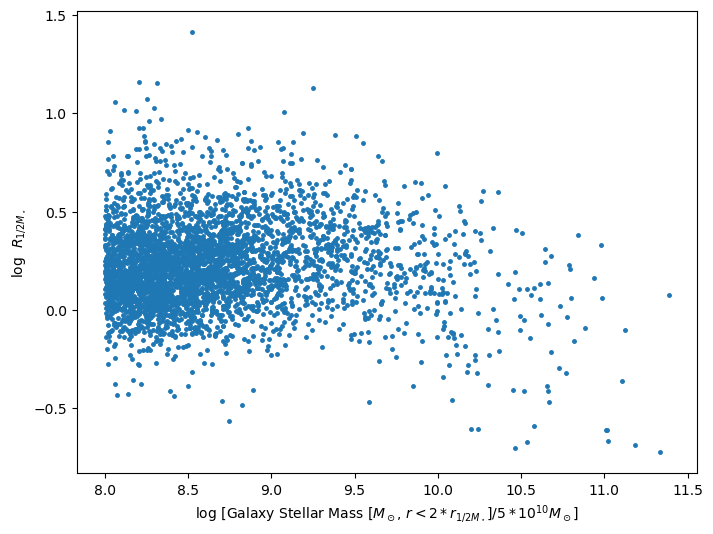

In [24]:
fig=plt.figure(figsize=(8,6))
ax=fig.add_subplot(111)
ax.plot(log_ms,log_reff,'.',markersize=5)

ax.set_xlabel('log [Galaxy Stellar Mass [$M_\odot$, $r < 2*r_{1/2 M_\star}]/5*10^{10}M_\odot$]')
ax.set_ylabel('log  $R_{1/2 M_\star}$')
plt.show()

## MASS-SIZE RELATION
Obtained by digitizing fig 1 from https://academic.oup.com/mnras/article/474/3/3976/4675227 <br>
86397091   |
+---------------------+-----------------------+<br>
|         x           |           y           |<br>
+---------------------+-----------------------+<br>
| 8.774031573738894  | 0.3064516982476391    |<br>
| 8.824246834304926  | 0.31182808269032103   |<br>
| 8.895982897372017  | 0.31451621338429453   |<br>
| 8.967718796248413  | 0.31989259782697643   |<br>
| 9.017934056814445  | 0.31451621338429453   |<br>
| 9.089670119881536  | 0.31989259782697643   |<br>
| 9.172166420008462  | 0.32526885921492316   |<br>
| 9.222381680574495  | 0.32526885921492316   |<br>
| 9.283357342391055  | 0.31720434407826775   |<br>
| 9.36226689683137   | 0.31720434407826775   |<br>
| 9.419655648770625  | 0.3064516982476391    |<br>
| 9.494978457524327  | 0.28763453728035504   |<br>
| 9.566714520591418  | 0.27957002214369964   |<br>
| 9.62769018240798   | 0.26881725325833555   |<br>
| 9.695839499788457  | 0.27688176839499073   |<br>
| 9.76040190729163   | 0.27688176839499073   |<br>
| 9.817790495040194  | 0.27688176839499073   |<br>
| 9.885939812420672  | 0.26344099187038883   |<br>
| 9.95408912980115   | 0.24193557715439612   |<br>
|10.015064627427018  | 0.22311841618711206   |<br>
|10.086800526303415  | 0.22043016243840338   |<br>
|10.154949843683893  | 0.2096775166077745    |<br>
|10.219512251187066  | 0.18817210189178177   |<br>
|10.284074658690239  | 0.16129042578784233   |<br>
|10.334289755065578  | 0.14247326482055828   |<br>
|10.40961256381928   | 0.10215068913728172   |<br>
|10.488522282450287  | 0.08602165886397091   |<br>
|10.560258181326684  | 0.08064515136655356   |<br>
|10.624820588829857  | 0.07258063622989816   |<br>
|10.68938299633303   | 0.05107534456864063   |<br>
|10.753945403836203  | 0.04569908318069413   |<br>
+---------------------+-----------------------+<br>

+---------------------+-----------------------+


In [25]:
data = [
    (8.774031573738894, 0.3064516982476391),
    (8.824246834304926, 0.31182808269032103),
    (8.895982897372017, 0.31451621338429453),
    (8.967718796248413, 0.31989259782697643),
    (9.017934056814445, 0.31451621338429453),
    (9.089670119881536, 0.31989259782697643),
    (9.172166420008462, 0.32526885921492316),
    (9.222381680574495, 0.32526885921492316),
    (9.283357342391055, 0.31720434407826775),
    (9.36226689683137, 0.31720434407826775),
    (9.419655648770625, 0.3064516982476391),
    (9.494978457524327, 0.28763453728035504),
    (9.566714520591418, 0.27957002214369964),
    (9.62769018240798, 0.26881725325833555),
    (9.695839499788457, 0.27688176839499073),
    (9.76040190729163, 0.27688176839499073),
    (9.817790495040194, 0.27688176839499073),
    (9.885939812420672, 0.26344099187038883),
    (9.95408912980115, 0.24193557715439612),
    (10.015064627427018, 0.22311841618711206),
    (10.086800526303415, 0.22043016243840338),
    (10.154949843683893, 0.2096775166077745),
    (10.219512251187066, 0.18817210189178177),
    (10.284074658690239, 0.16129042578784233),
    (10.334289755065578, 0.14247326482055828),
    (10.40961256381928, 0.10215068913728172),
    (10.488522282450287, 0.08602165886397091),
    (10.560258181326684, 0.08064515136655356),
    (10.624820588829857, 0.07258063622989816),
    (10.68938299633303, 0.05107534456864063),
    (10.753945403836203, 0.04569908318069413)
]

x_values = np.array([item[0] for item in data])
y_values = np.array([item[1] for item in data])

In [35]:
z=np.poly1d(np.polyfit(x_values,y_values,6))
z

poly1d([ 9.20404403e-02, -5.24261450e+00,  1.24240064e+02, -1.56792592e+03,
        1.11136013e+04, -4.19482389e+04,  6.58687776e+04])

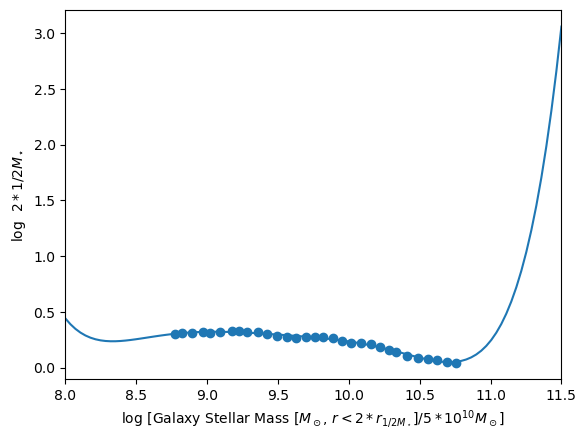

In [36]:
x=np.linspace(8,11.5,100)
plt.scatter(x_values,y_values)
plt.plot(x,z(x))
plt.xlabel('log [Galaxy Stellar Mass [$M_\odot$, $r < 2*r_{1/2 M_\star}]/5*10^{10}M_\odot$]')
plt.ylabel('log  $2*{1/2 M_\star}$')
plt.xlim(8,11.5)
plt.show()

## MATCHING

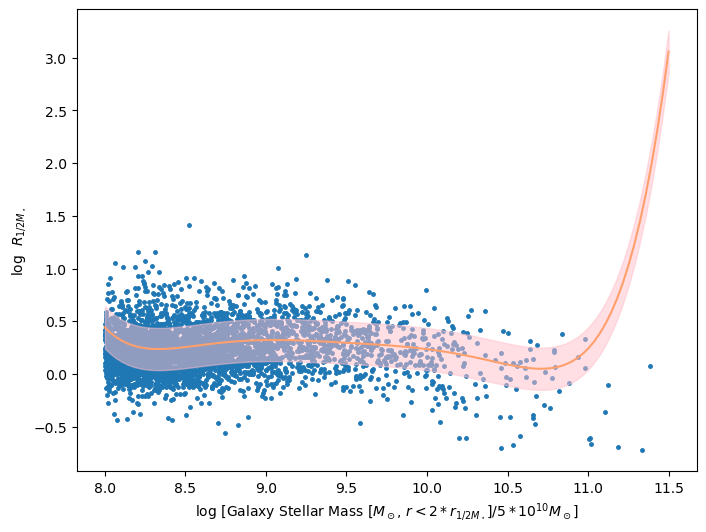

In [39]:
fig=plt.figure(figsize=(8,6))
ax=fig.add_subplot(111)
ax.plot(log_ms,log_reff,'.',markersize=5)
ax.plot(x,z(x))
ax.fill_between(x,z(x)+0.2,z(x)-0.2,color='pink',alpha=0.5,zorder=2)

ax.set_xlabel('log [Galaxy Stellar Mass [$M_\odot$, $r < 2*r_{1/2 M_\star}]/5*10^{10}M_\odot$]')
ax.set_ylabel('log  $R_{1/2 M_\star}$')
plt.show()

In [43]:
good_ones=np.where(abs(z(log_ms)-log_reff)<=0.4)
fields=[z1_Subhalomass_gas,z1_Subhalomass_star,z1_Subhalomass_dm,z1_Subhalo_reff,z1_Subhalo_sreff,z1_Subhalo_sfr,z1_Subhalo_Vmax,z1_Subhalo_Sigma,z1_Subhalo_mass,z1]

newfields=[field[good_ones] for field in fields]
z1_Subhalomass_gas,z1_Subhalomass_star,z1_Subhalomass_dm,z1_Subhalo_reff,z1_Subhalo_sreff,z1_Subhalo_sfr,z1_Subhalo_Vmax,z1_Subhalo_Sigma,z1_Subhalo_mass,z1=newfields

In [46]:
log_ms=np.log10(z1_Subhalomass_star)
log_reff=np.log10(z1_Subhalo_sreff)

In [47]:
logms_binned,logreff_binned=bin_data(log_ms,log_reff,20)

In [48]:
x_plot=np.linspace(log_ms.min(),log_ms.max(),100)

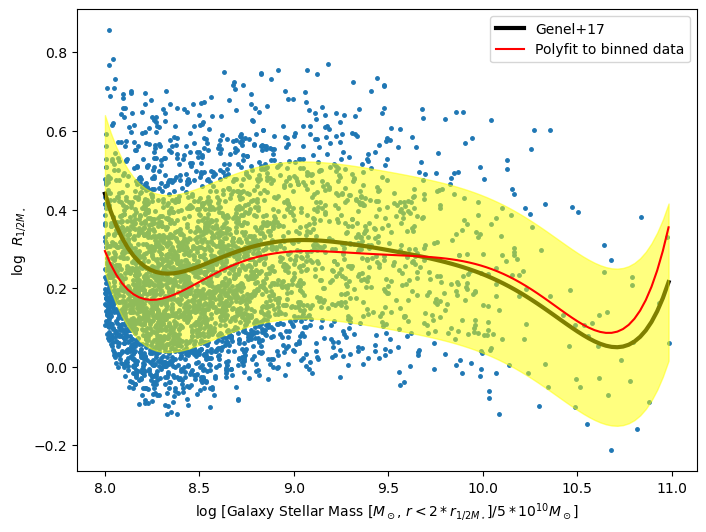

In [49]:
poly_bins=np.poly1d(np.polyfit(logms_binned,logreff_binned,6))

fig=plt.figure(figsize=(8,6))
ax=fig.add_subplot(111)
ax.plot(log_ms,log_reff,'.',markersize=5)
ax.plot(x_plot,z(x_plot),color='black',label='Genel+17',linewidth=3)
ax.plot(x_plot,poly_bins(x_plot),color='red',zorder=3,label='Polyfit to binned data')
ax.fill_between(x_plot,z(x_plot)+0.2,z(x_plot)-0.2,color='yellow',alpha=0.5,zorder=2)

ax.set_xlabel('log [Galaxy Stellar Mass [$M_\odot$, $r < 2*r_{1/2 M_\star}]/5*10^{10}M_\odot$]')
ax.set_ylabel('log  $R_{1/2 M_\star}$')
ax.legend()
plt.show()

In [50]:
df=pd.DataFrame({'$M_{gas},M_{\odot}$':z1_Subhalomass_gas,'$M_{stellar},M_{\odot}$':z1_Subhalomass_star,'$M_{DM},M_{\odot}$':z1_Subhalomass_dm,'$R_{eff}$(kpc)':z1_Subhalo_reff,'SFR($M_{\odot}/yr$)':z1_Subhalo_sfr,'$V_{max}$(km/s)':z1_Subhalo_Vmax,'$\sigma_v$(km/s)':z1_Subhalo_Sigma,
                'M':z1_Subhalo_mass,'z':z1.reshape(len(z1),)})
df

,"$M_{gas},M_{\odot}$","$M_{stellar},M_{\odot}$","$M_{DM},M_{\odot}$",$R_{eff}$(kpc),SFR($M_{\odot}/yr$),$V_{max}$(km/s),$\sigma_v$(km/s),M,z
0,3.137059e+10,1.667449e+10,1.801137e+11,13.113566,24.230335,214.248520,120.097977,2.281741e+11,3
1,3.260930e+10,6.073629e+09,1.623722e+11,13.045609,9.134394,182.851151,109.356224,2.010634e+11,3
2,2.049460e+10,9.703567e+09,1.390070e+11,11.715428,9.345250,209.860718,109.523285,1.692249e+11,3
3,3.039812e+09,3.092485e+09,1.412149e+10,2.939512,3.637235,123.416046,72.375122,2.025965e+10,3
4,2.861217e+09,2.634628e+08,3.357858e+10,11.661683,0.286968,83.820358,48.046841,3.670326e+10,3
...,...,...,...,...,...,...,...,...,...
3455,1.801530e+09,1.079494e+08,1.897522e+10,8.925103,0.147883,71.231163,41.894878,2.088469e+10,3
3456,1.873550e+09,1.149888e+08,1.678680e+10,8.576305,0.146461,68.819817,41.658970,1.877533e+10,3
3457,1.948300e+09,1.505584e+08,1.681810e+10,7.932831,0.225469,71.924347,42.229591,1.891696e+10,3
3458,1.949861e+09,1.096326e+08,1.502082e+10,8.522322,0.146249,65.825821,37.454998,1.708031e+10,3


In [51]:
df.to_csv('2.45-3.05.csv')